# A) Recursive GLS

### [A.1] Import Packages

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [3]:
def get_batch(y, t, knots, iteration, mode):
    np.random.seed(iteration)
    print('\nseed= ',iteration)
    
    if mode == "single_uniform":
        idx = np.arange(0, t.shape[0], (t.shape[0]/knots))
        t_knots = np.array(t[idx])
        return t_knots#,idx
    
    elif mode == "single_random":
        idx = np.random.choice(len(t), size = knots, replace = False) 
        idx=np.sort(idx)
        t_knots = np.array(t[idx])
        #print(t_knots)
        return t_knots#,idx
    
    elif mode == "block_random":
        idx = np.random.choice(len(t), size = t.shape[0], replace = False) 
        t_knots = np.array(t[idx])
        return t_knots#,idx
    
    elif mode == "block_uniform":
        t_knots = np.array(t)
        return t_knots
    
    elif mode== "mid_point":
        idx = int(t.shape[0]/2)
        t_knots = np.array(t[idx])
        return t_knots

    elif mode== "mid_end_point":
        idx = int(t.shape[0]/2)
        idx2= t.shape[0]-1
        t_knots = np.array([t[idx], t[idx2]])
        return t_knots
    
    else:
        t_knots = np.array([])
        return t_knots
    
def get_tk(t_knots, iteration, mode):
    print(t_knots.size)
    if mode == "single_uniform" or mode == "single_random" or mode=="mid_point" or mode == "mid_end_point":
        if t_knots.size==1:
            tk=t_knots
        if t_knots.size==2:
            tk=t_knots
        else:
            tk = np.array([t_knots[iteration]])
        return tk
    
    elif mode == "block_uniform" or mode == "block_random":
        idx = np.arange((iteration)*knots,(iteration+1)*knots)
        tk = np.array(t_knots[idx])
        return tk
    

### [A.3] Get Tau Forward and Tau Backward

In [4]:
def get_tau(y, t, ti):
    F_indices = np.where(t <= ti)[0]
    B_indices = np.where(t > ti)[0]
    tau_F = t[F_indices]
    tau_B = t[B_indices]
    return tau_F, tau_B

### [A.4] Calculate Annihilator Terms

In [5]:
def get_alpha_tau(ti, tau_F, tau_B, a, b, n):
    f = np.math.factorial
    
    #Calculate alpha forward
    delta_time_F = np.array((ti - tau_F)**(n-1))
    delta_tau_F = np.array((tau_F - a)**4)
    alpha_F = np.multiply(delta_time_F, delta_tau_F)
    
    #Calculate alpha backward
    delta_time_B = np.array((ti - tau_B)**(n-1))
    delta_tau_B = np.array((b - tau_B)**4)
    alpha_B = np.multiply(delta_time_B, delta_tau_B)
    
    alpha = np.concatenate((alpha_F, alpha_B), axis = 0)
    alpha = np.array(alpha/f(n-1))
    return alpha

### [A.5] Calculate Kernels for Q and P Matrices

In [6]:
def get_KFn_vector(ti, tau_F, a, n):
    if tau_F.size == 1:
        tau_F = np.array([tau_F])
    N_tau = tau_F.shape[0]
    f = np.math.factorial
    gamma = np.zeros((4, N_tau))
    zeta = np.zeros((5, N_tau))
    delta = np.array(tau_F - a)
    
    for i in range(0, 4):
        gamma[i, :] = np.array(((ti - tau_F)**(n+i))/(f(n+i)))
        
    zeta[3, :] = np.array(gamma[0, :]*(-1.0)*(delta**4)
                          +gamma[1, :]*(12.0)*(delta**3)
                          +gamma[2, :]*(-36.0)*(delta**2)
                          +gamma[3, :]*(24.0)*(delta))
    
    zeta[2, :] = np.array(gamma[1, :]*(-1.0)*(delta**4)
                          +gamma[2, :]*(8.0)*(delta**3)
                          +gamma[3, :]*(-12.0)*(delta**2))
    
    zeta[1, :] = np.array(gamma[2, :]*(-1.0)*(delta**4)
                          +gamma[3, :]*(4.0)*(delta**3))
    
    zeta[0, :] = np.array(gamma[3, :]*(-1.0)*(delta**4))
    
    zeta[4, :] = np.array(gamma[0, :]*(16.0)*(delta**3)
                          +gamma[1, :]*(-72.0)*(delta**2)
                          +gamma[2, :]*(96.0)*(delta)
                          +gamma[3, :]*(-24.0)*(np.ones(N_tau)))
    
    return zeta



def get_KBn_vector(ti, tau_B, b, n):
    if tau_B.size == 1:
        tau_B = np.array([tau_B])
    N_tau = tau_B.shape[0]
    f = np.math.factorial
    gamma = np.zeros((4, N_tau))
    zeta = np.zeros((5, N_tau))
    delta = np.array(b - tau_B)
    
    #Santosh Derivation
    for i in range(0, 4):
        gamma[i, :] = np.array(((ti - tau_B)**(n+i))/(f(n+i)))
    
    
    zeta[3, :] = np.array(gamma[0, :]*(1.0)*(delta**4)
                          +gamma[1, :]*(12.0)*(delta**3)
                          +gamma[2, :]*(36.0)*(delta**2)
                          +gamma[3, :]*(24.0)*(delta))
    
    zeta[2, :] = np.array(gamma[1, :]*(1.0)*(delta**4)
                          +gamma[2, :]*(8.0)*(delta**3)
                          +gamma[3, :]*(12.0)*(delta**2))
    
    zeta[1, :] = np.array(gamma[2, :]*(1.0)*(delta**4)
                          +gamma[3, :]*(4.0)*(delta**3))
    
    zeta[0, :] = np.array(gamma[3, :]*(1.0)*(delta**4))
    
    zeta[4, :] = np.array(gamma[0, :]*(16.0)*(delta**3)
                          +gamma[1, :]*(72.0)*(delta**2)
                          +gamma[2, :]*(96.0)*(delta)
                          +gamma[3, :]*(24.0)*(np.ones(N_tau)))
    
    if n > 0:
        zeta = np.array(-1.0*zeta)
    return zeta
    

### [A.6] Calculate Kernels for S Matrix

In [7]:
def get_KDSn(ti, tau_F, tau_B, a, b, n, ak):
    print(f"ak is {ak} in get_KDSn")

    beta = np.concatenate((ak, 1), axis = None)
    beta = beta.reshape(5,1)
    
    KFn_vector = get_KFn_vector(ti, tau_F, a, n)
    KBn_vector = get_KBn_vector(ti, tau_B, b, n)
    KDSn_vector = np.concatenate((KFn_vector, KBn_vector), axis = 1)
    
    KDSn = np.multiply(beta, KDSn_vector)
    KDSn = np.sum(KDSn, axis = 0)
    return KDSn

def get_KFn(ti, tau_F, a, n, ak):
    beta = np.concatenate((ak, 1), axis = None)
    beta = beta.reshape(5,1)
    
    KFn_vector = get_KFn_vector(ti, tau_F, a, n)
    KFn = np.multiply(beta, KFn_vector)
    KFn = np.sum(KFn, axis = 0)
    return KFn

def get_KBn(ti, tau_B, b, n, ak):
    beta = np.concatenate((ak, 1), axis = None)
    beta = beta.reshape(5,1)
    
    KBn_vector = get_KBn_vector(ti, tau_B, b, n)
    KBn = np.multiply(beta, KBn_vector)
    KBn = np.sum(KBn, axis = 0)
    return KBn

### [A.7] Calculate LHS

In [8]:
def get_LHS(y, t, tk, a, b, n):
    f = np.math.factorial
    
    if tk.size!=1:
        N = tk.shape[0]
    elif tk.size==1:
        N=1
    #print('\nstart time ',tk)
    
    LHS_n = np.zeros(N)
    r = 0
    print(f"tk is {tk}")
    if(tk.size==1):
        ti=tk
        tau_F, tau_B = get_tau(y, t, ti)

        #Calculate alpha
        alpha = get_alpha_tau(ti, tau_F, tau_B, a, b, n)

        #Calculate Integrand:
        integrand = np.multiply(alpha, y)

        #Integrate
        integral = np.trapz(integrand, t)

        #Store value
        LHS_n[r] = np.array((integral))
    else:
        for ti in tk:

            tau_F, tau_B = get_tau(y, t, ti)

            #Calculate alpha
            alpha = get_alpha_tau(ti, tau_F, tau_B, a, b, n)

            #Calculate Integrand:
            integrand = np.multiply(alpha, y)

            #Integrate
            integral = np.trapz(integrand, t)

            #Store value
            LHS_n[r] = np.array((integral))
            r += 1
    
    return LHS_n


### [A.8] Calculate RHS

In [9]:
def get_RHS(y, t, tk, a, b, n):
    f = np.math.factorial
    if tk.size!=1:
        N = tk.shape[0]
    elif tk.size==1:
        N=1
    print('start time ',tk)
    
    RHS_n = np.zeros((N, 5))
    
    r = 0
    
    if(tk.size==1):
        ti=tk
        tau_F, tau_B = get_tau(y, t, ti)

        #Calculate Kernel vector
        KFn_vector = get_KFn_vector(ti, tau_F, a, n)
        KBn_vector = get_KBn_vector(ti, tau_B, b, n)
        KDSn_vector = np.concatenate((KFn_vector, KBn_vector), axis = 1)

        #Calculate integrands
        integrand = np.multiply(KDSn_vector, y)

        #Integrate
        for k in range(0, 5):
            RHS_n[r, k] = np.trapz(integrand[k, :], t)
    else:
        for ti in tk:
            tau_F, tau_B = get_tau(y, t, ti)

            #Calculate Kernel vector
            KFn_vector = get_KFn_vector(ti, tau_F, a, n)
            KBn_vector = get_KBn_vector(ti, tau_B, b, n)
            KDSn_vector = np.concatenate((KFn_vector, KBn_vector), axis = 1)

            #Calculate integrands
            integrand = np.multiply(KDSn_vector, y)

            #Integrate
            for k in range(0, 5):
                RHS_n[r, k] = np.trapz(integrand[k, :], t)

            r += 1

    return RHS_n

### [A.9] Calculate Q and P matrices

In [10]:
def get_P_Q(y, t, tk, a, b, n_max,plot=False):
    f = np.math.factorial
    
    n_min=n_max-4
    n_vector = np.arange(n_min, n_max)
    
    for n in n_vector:
        print('\n n= ',n)
        
        LHS_n = get_LHS(y, t, tk, a, b, n)
        RHS_n = get_RHS(y, t, tk, a, b, n)
        
        if n == n_vector[0]:
            LHS = np.array(LHS_n)
            RHS = np.array(RHS_n)
        else:
            LHS = np.concatenate((LHS, LHS_n), axis = None)
            RHS = np.vstack((RHS, RHS_n))
    

    #Arrange P:
    P = np.array(RHS[:, 0:4])
    #Arrange Q:
    Q = np.subtract(LHS, RHS[:, 4])
    
    
    if plot==True:
        plt.figure(figsize=(10,7))
        for i in range (1,n_max-n_min+1):
            lab='n= '+str(n_min-1+i)
            plt.plot(tk,LHS[knots*(i-1):knots*i]-(RHS[knots*(i-1):knots*i,0]*1+RHS[knots*(i-1):knots*i,1]*5+RHS[knots*(i-1):knots*i,2]*5+RHS[knots*(i-1):knots*i,3]*0+RHS[knots*(i-1):knots*i,4]),label=lab)
            plt.legend(loc='best')
        
        print('\nParameter Estimates for individual eqns')
        for i in range(1,n_max-n_min+1):
            print('\nn= ',n_min-1+i)
            print( np.matmul(np.linalg.pinv(P[knots*(i-1):knots*i]), Q[knots*(i-1):knots*i]))
            
        plt.figure(figsize=(25,10))
        chart=1
        for i in range(1,n_max-n_min+1):
            plt.subplot(n_max-n_min+1,5, chart)
            lab='a3_RHS_'+str(n_min-1+i)
            plt.plot(tk, RHS[knots*(i-1):knots*i,0], 'b', label=lab)
            plt.legend(loc='best')
            chart+=1
            plt.subplot(n_max-n_min+1, 5, chart)
            lab='a2_RHS_'+str(n_min-1+i)
            plt.plot(tk, RHS[knots*(i-1):knots*i,1], 'g', label=lab)
            plt.legend(loc='best')
            chart+=1
            plt.subplot(n_max-n_min+1, 5, chart)
            lab='a1_RHS_'+str(n_min-1+i)
            plt.plot(tk, RHS[knots*(i-1):knots*i,2], 'r', label=lab)
            plt.legend(loc='best')
            chart+=1
            plt.subplot(n_max-n_min+1, 5, chart)
            lab='a0_RHS_'+str(n_min-1+i)
            plt.plot(tk, RHS[knots*(i-1):knots*i,3], 'm', label='a0_RHS_1')
            plt.legend(loc='best')
            chart+=1
            plt.subplot(n_max-n_min+1, 5, chart)
            lab='const_RHS_'+str(n_min-1+i)
            plt.plot(tk, RHS[knots*(i-1):knots*i,4], 'm', label=lab)
            plt.legend(loc='best')
            chart+=1
            
    return P, Q

dxdt size:  [0.0, 0.0, 1.0, 0.0]
dxdt size:  [4.911364238221749e-26, 3.6621324525111905e-09, 1.0, -2.4556821191108747e-25]
dxdt size:  [3.9290913941746126e-25, 7.324264905022381e-09, 1.0, -1.964545698885913e-24]
dxdt size:  [4.914311646173977e-14, 3.6628648790016925e-05, 1.0, -2.457178323659156e-13]
dxdt size:  [3.930306229591565e-13, 7.324997331512883e-05, 1.0, -1.9651711044597184e-12]
dxdt size:  [1.3263632621170314e-12, 0.00010987129784024073, 0.9999999999999999, -6.6318500358401695e-12]
dxdt size:  [1.0790988771893252e-10, 0.00047608454309135936, 0.9999999999999889, -5.396024790252528e-10]
dxdt size:  [1.0792769487424879e-10, 0.0004760845430913577, 0.9999999999998999, -5.396024790252471e-10]
dxdt size:  [5.976603652522924e-10, 0.0008422977883424053, 0.9999999999996046, -2.988535555083262e-09]
dxdt size:  [5.977305191376797e-10, 0.0008422977883423696, 0.9999999999992538, -2.988535555082881e-09]
dxdt size:  [1.7654868966232665e-09, 0.0012085110335930329, 0.9999999999977109, -8.827811

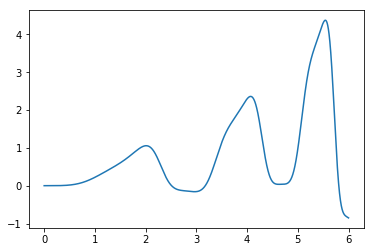

Wall time: 274 ms


In [13]:
 %%time
# def system(x, t):
    
#     dx = np.zeros_like(x)
    
#     A = np.array(np.eye(4))
#     A[0][0] = 0
#     A[0][1] = 1
#     A[1][1] = 0
#     A[1][2] = 1
#     A[2][0] = 0
#     A[2][1] = 0
#     A[2][2] = 0
#     A[2][3] = 1
#     A[3][0] = -1
#     A[3][1] = -5
#     A[3][2] = -5
#     A[3][3] = 0
#     #print(dx)
#     x_0, x_1, x_2, x_3 = x
#     #print(dx.shape)
#     dx[0] = A[0][0]*x_0 + A[0][1]*x_1 + A[0][2]*x_2 + A[0][3]*x_3
#     dx[1] = A[1][0]*x_0 + A[1][1]*x_1 + A[1][2]*x_2 + A[1][3]*x_3
#     dx[2] = A[2][0]*x_0 + A[2][1]*x_1 + A[2][2]*x_2 + A[2][3]*x_3
#     dx[3] = A[3][0]*(x_0**3) + A[3][1]*(x_1**3) + A[3][2]*x_2 + A[3][3]*x_3
    
#     return dx

#System definition
def system(x,t):
    ai=[1,5,5,0]
    x1 = x[0]
    x2 = x[1]
    x3 = x[2]
    x4 = x[3]
    dx1dt = x2**5 + x3**3 + x1
    dx2dt = x3#**4
    dx3dt = x4
    dx4dt = (-ai[0])*(x1**2) + (-ai[1])*(x2**2) + (-ai[2])*(x3**3) + (-ai[3])*x4
    dxdt = [dx1dt, dx2dt, dx3dt, dx4dt]
    print("dxdt size: ", dxdt)
    return dxdt


knots = 2
a = 0 
b = 6
t = np.linspace(0,6,200000)
#x0 = [0, 1, 0, 0] #Initial conditions
x0 = [0, 0, 0, 1]
xsol = odeint(system, x0, t)
y = xsol[:,0]
ydot = xsol[:,1]
ydotdot = xsol[:,2]
ydotdotdot = xsol[:,3]
plt.figure()
plt.plot(t,y)
plt.show()

In [14]:
%%time
def gaussian_noise(y, t, mean, std):
    noise = np.random.normal(mean, std, t.shape[0])
    ynoise = np.array(y + noise)
    #ynoise = y + noise
    return ynoise

#P, Q = PQ(y, t, a, b, knots,iteration)
knots=3
ynoise = gaussian_noise(y, t, 0, 1)
iteration=0
t_knots_trial = get_batch(y, t, knots, iteration, mode='mid_end_point')
print(t_knots_trial)
tk = get_tk(t_knots_trial, iteration, mode='mid_point')



seed=  0
[3.000015 6.      ]
2
Wall time: 12.9 ms


In [15]:
P, Q = get_P_Q(ynoise, t, t_knots_trial, a, b, n_max=7,plot=False)
#PQ(ynoise, t, a, b, knots,iteration)
Pin = np.linalg.pinv(P)
a_est = np.matmul(Pin, Q)
print('\n')
print(P.shape)
print(Q.shape)
print(a_est)


 n=  3
tk is [3.000015 6.      ]
start time  [3.000015 6.      ]

 n=  4
tk is [3.000015 6.      ]
start time  [3.000015 6.      ]

 n=  5
tk is [3.000015 6.      ]
start time  [3.000015 6.      ]

 n=  6
tk is [3.000015 6.      ]
start time  [3.000015 6.      ]


(8, 4)
(8,)
[  9.40312237 -28.91073679   9.66184292  -4.72088774]


### [A.10] Calculate S Matrix

In [16]:
#Diagonal Covariance Matrix
def get_S(y, t, tk, a, b, ak, n_max, var): 
    
    f = np.math.factorial
    
    if(tk.size==1):
        N=1
    else:
        N = tk.shape[0]
    
    n_vector = np.arange(n_max - 4, n_max)
    
    S = np.zeros(((n_vector.shape[0])*N, (n_vector.shape[0])*N))
    
    m = 0
    for n in n_vector:
        Cov_inv = np.zeros((N, N))
        
        r1 = 0
        if(tk.size==1):
            ti=tk
            tau_F, tau_B = get_tau(y, t, ti)

            KDSn = get_KDSn(ti, tau_F, tau_B, a, b, n, ak)
            alpha = get_alpha_tau(ti, tau_F, tau_B, a, b, n)
            integrand = np.array((alpha - KDSn)**2)

            Cov = np.array((var**2)*(np.trapz(integrand, t)))
            Cov_inv[r1,r1] = np.array(1/Cov) #np.linalg.inv(Cov) #np.array(1/Cov)-Shantanil
            #print('**r1**\n',r1)
            #print('***Cov***\n',Cov)
            #print('******\n\n')
            r1 += 1
        else:
            for ti in tk:
                tau_F, tau_B = get_tau(y, t, ti)

                KDSn = get_KDSn(ti, tau_F, tau_B, a, b, n, ak)
                alpha = get_alpha_tau(ti, tau_F, tau_B, a, b, n)
                integrand = np.array((alpha - KDSn)**2)

                Cov = np.array((var**2)*(np.trapz(integrand, t)))
                Cov_inv[r1,r1] = np.array(1/Cov) #np.linalg.inv(Cov) #np.array(1/Cov)-Shantanil
                #print('**r1**\n',r1)
                #print('***Cov***\n',Cov)
                #print('******\n\n')
                r1 += 1
        
        S[(m)*N: (m+1)*N, (m)*N: (m+1)*N] = np.array(Cov_inv)
        
        m += 1
    print('\n***S (Diagonal_Covariance)***\n',S)
    print('******\n\n')    
    return S

#Full Covariance Matrix
def get_S1(y, t, tk, a, b, ak, n_max, var):
    f = np.math.factorial
        
    N = tk.shape[0]
    N_ext = t.shape[0]
    n_vector = np.arange(n_max - 4, n_max)
    
    S = np.zeros(((n_vector.shape[0])*N, (n_vector.shape[0])*N))
    
    m = 0
    for n in n_vector:
        Cov = np.zeros((N, N))
        KDSn_tau = np.zeros((N, N_ext))
        alpha = np.zeros((N, N_ext))
        
        r1 = 0
        for ti in tk:
            tau_F, tau_B = get_tau(y, t, ti)

            KDSn_tau[r1, :] = get_KDSn(ti, tau_F, tau_B, a, b, n, ak)

            alpha[r1, :] = get_alpha_tau(ti, tau_F, tau_B, a, b, n)

            r1 += 1

        for r1 in range(0, N):
            for r2 in range(r1, N):
                #Get first term of the E(e^n*e^n)
                Cov1 = np.multiply(alpha[r1, :], alpha[r2, :])
                #Get second term of the E(e^n*e^n)
                Cov2 = np.multiply(alpha[r1, :], KDSn_tau[r2, :])
                #Get third term of the E(e^n*e^n)
                Cov3 = np.multiply(alpha[r2, :], KDSn_tau[r1, :])
                #Get fourth term of the E(e^n*e^n)
                Cov4 = np.multiply(KDSn_tau[r1, :], KDSn_tau[r2, :])

                #Since all of these terms have the same differential, they can be integrated all together.
                integrand = np.array((var**2)*(Cov1 - Cov2 - Cov3 + Cov4))

                Cov[r1, r2] = np.trapz(integrand, t)

                #Setup symmetry
                Cov[r2, r1] = np.array(Cov[r1, r2])

        #Concatenate results:
        S[(m)*N : (m+1)*N, (m)*N : (m+1)*N] = np.linalg.inv(Cov)
        m += 1
    
    return S

### [A.11] Reconstruct yE(t)

In [17]:
def get_fund_eqtns(y, t, ak):
    canon = np.array([[0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, 0.0],
                [0.0, 0.0, 0.0, 1.0]])

    ak = ak.reshape(1, 4)
    canon = np.vstack((canon, -1.0*ak))
    
    w, v = np.linalg.eig(canon)
    w_ext = np.zeros((4,2))
    for i in range(0, 4):
        w_ext[i, 0] = np.real(w[i])
        w_ext[i, 1] = np.abs(np.imag(w[i]))
    #Separate Repeated Roots:
    unique = np.sort(np.unique(w_ext, return_index=True, axis = 0)[1])
    roots = {}
    n = 0
    for i in unique:
        w_i = w_ext[i, :]

        #Find repeated real roots
        if w_i[1] < 0.01:
            idx_repeated = np.where(w_i[0] == w_ext[:,0])[0]
            roots[n] = np.array(w_ext[idx_repeated,:])
        else:
            idx_r_repeated = np.where(w_i[0] == w_ext[:,0])[0]
            idx_c_repeated = np.where(w_i[1] == w_ext[:,1])[0]
            idx_repeated = idx_r_repeated[np.where(idx_r_repeated == idx_r_repeated)[0]]    
            roots[n] = np.array(w_ext[idx_repeated])
        n += 1

    #Calculate Fundamental Solutions:
    eta = np.zeros((4, t.shape[0]))
    i = 0
    for n in range(0, len(roots)):
        root_n = np.array(roots[n])
        if root_n.shape[0] == 1:
            eta[i, :] = np.array(np.exp(root_n[0,0]*t))
            i += 1
        elif root_n.shape[0] == 2:
            if root_n[0,1] < 0.01:
                exp = np.exp(root_n[0,0]*t)
                eta[i, :] = np.array(exp)
                i += 1
                eta[i, :] = np.multiply(t, exp)
                i += 1
            else:
                real = np.array(root_n[0,0])
                imag = np.array(root_n[0,1])
                exp = np.exp(real*t)
                eta[i, :] = np.multiply(exp, np.cos(imag*t))
                i += 1
                eta[i, :] = np.multiply(exp, np.sin(imag*t))
                i += 1
        elif root_n.shape[0] == 3:
            exp = np.exp(root_n[0,0]*t)
            eta[i, :] = np.array(exp)
            i += 1
            eta[i, :] = np.multiply(t, exp)
            i += 1        
            eta[i, :] = np.multiply(t**2, exp)
            i += 1                
        elif root_n.shape[0] == 4:
            if root_n[0,1] < 0.01:
                exp = np.exp(root_n[0,0]*t)
                eta[i, :] = np.array(exp)
                i += 1
                eta[i, :] = np.multiply(t, exp)
                i += 1        
                eta[i, :] = np.multiply(t**2, exp)
                i += 1
                eta[i, :] = np.multiply(t**3, exp)
                i += 1
            else:
                real = np.array(root_n[0,0])
                imag = np.array(root_n[0,1])
                exp = np.exp(real*t)
                texp = np.multiply(t, exp)
                eta[i, :] = np.multiply(exp, np.cos(imag*t))
                i += 1
                eta[i, :] = np.multiply(exp, np.sin(imag*t))
                i += 1 
                eta[i, :] = np.multiply(texp, np.cos(imag*t))
                i += 1
                eta[i, :] = np.multiply(texp, np.sin(imag*t))
                i += 1 
    return eta

#Define L2 inner product
def L2p(f, g, t):
    integrand = np.multiply(f, g)
    integral = np.trapz(integrand, t)
    return integral

#Orthonormalize the fundamental equations
def orthonormalize(eta, t):
    N = t.shape[0]
    v = np.zeros((4, N))
    u = np.zeros((4, N))
    
    v[0, :] = np.array(eta[0, :])
    
    v[1, :] = np.array(eta[1, :] 
                       - ((L2p(eta[1, :], v[0, :], t)/L2p(v[0, :], v[0, :], t))*v[0, :]))

    v[2, :] = np.array(eta[2, :] 
                       - ((L2p(eta[2, :], v[0, :], t)/L2p(v[0, :], v[0, :], t))*v[0, :])
                      - ((L2p(eta[2, :], v[1, :], t)/L2p(v[1, :], v[1, :], t))*v[1, :]))
    
    v[3, :] = np.array(eta[3, :] 
                       - ((L2p(eta[3, :], v[0, :], t)/L2p(v[0, :], v[0, :], t))*v[0, :])
                      - ((L2p(eta[3, :], v[1, :], t)/L2p(v[1, :], v[1, :], t))*v[1, :])
                       - ((L2p(eta[3, :], v[2, :], t)/L2p(v[2, :], v[2, :], t))*v[2, :]))
    
    for i in range(0, 4):
        u[i, :] = np.array(v[i, :]/np.sqrt(L2p(v[i, :], v[i, :], t)))
    
    return u

#Reconstruct yE(t)
def get_yE(y, t, ak):
    N = t.shape[0]
    yE = np.zeros((4, N))
    
    #Get orthonormal vectors
    eta = get_fund_eqtns(y, t, ak)
    print("eta",eta)
    u = orthonormalize(eta, t)
    print("u:",u)
    inner_prod = np.zeros(4)
    for i in range(0, 4):
        inner_prod[i] = L2p(y, u[i, :], t)
        yE[i, :] = np.array(inner_prod[i]*u[i, :])
    yE = np.sum(yE, axis = 0)
    return yE

# OLS for Initial Estimation

In [18]:
def OLS(y, t, a, b, knots, n_max):
    #Find identifiable points
    z = 0
    for k in range(0, t.shape[0]):
        if z == knots:
            break
        P, Q = get_P_Q(y, t, a, b, 1, k, "random", n_max)
        if np.abs(np.linalg.det(P)) > 1.0:
            if z == 0:
                tk = np.array(get_batch(y, t, 1, k, "random")[0])
                idx = np.where(t == tk)[0]
                yk = np.array(y[idx])
                Ptotal = np.array(P)
                Qtotal = np.array(Q)
            else:
                ti = np.array(get_batch(y, t, 1, k, "random")[0])
                idx = np.where(t == ti)[0]
                yi = np.array(y[idx])
                tk = np.concatenate((tk, ti), axis = None)
                yk = np.concatenate((yk, yi), axis = None)
                Ptotal = np.concatenate((Ptotal, P), axis = 0)
                Qtotal = np.concatenate((Qtotal, Q), axis = None)
            z +=1

    a_OLS = np.matmul(np.linalg.pinv(Ptotal), Qtotal)
    return a_OLS

# RLS with Identifiable Point Search

In [19]:
def initial_Rk(P, S):
    #Calculate initial Rk
    PT = np.transpose(P)
    PTS = np.matmul(PT, S)
    Mk1 = np.matmul(PTS, P)
    Rk = np.linalg.inv(Mk1)
    return Rk


def get_Rk1(P, S, Rk):
    #Calculate r_1 = (S^-1 + P*Rk*PT)^-1
    PT = np.transpose(P)
    S_inv = np.linalg.inv(S)
    RPT = np.matmul(Rk, PT)
    PRPT = np.matmul(P, RPT)
    r_1 = np.add(S_inv, PRPT)
    r_1 = np.linalg.inv(r_1)
    
    #Calculate r_2 = Rk*PT*r_1 =Rk*PT*(S^-1 + P*Rk*PT)^-1
    r_2 = np.matmul(RPT, r_1)
    
    #Calculate r_3 = r_2*P*Rk =Rk*PT*(S^-1 + P*Rk*PT)^-1*P*Rk
    PR = np.matmul(P, Rk)
    r_3 = np.matmul(r_2, PR)
    
    #Calculate Rk1
    Rk1 = np.subtract(Rk, r_3)
    
    return Rk1


def get_ak1(Q, P, S, ak, Rk1):
    #Calculate a_1 = (Q - P*ak)
    Pa = np.matmul(P, ak)
    a_1 = np.subtract(Q, Pa)
    
    #Calculate a_2 = Rk1*PT*S
    PT = np.transpose(P)
    PTS = np.matmul(PT, S)
    a_2 = np.matmul(Rk1, PTS)
    
    #Calculate a_3 = a_2*a_1 = Rk1*PT*S*(Q - P*ak)
    a_3 = np.matmul(a_2, a_1)
    
    #Calculate ak1
    ak1 = np.add(ak, a_3)
    
    return ak1

In [20]:
def RLS(y, t, a, b, knots, mode, n_max, tol, ak_init):
    #Set initial iteration
    iteration = 0
    eps = np.inf
    
    #Define Time Points:
    t_knots = get_batch(y, t, knots, iteration, mode)
    print('\n t_knots= ',t_knots)
    
    if t_knots.size == 0:
        print("WARNING! ALGORITHM STOPPED: Mode name incorrectly specified")
        ak, ak_log = None, None
        return ak, ak_log
    
    #Set initial conditions
#     ak = np.array([0.0, 0.0, 0.0, 0.0])
    ak=ak_init
    #Store parameter estimation per iteration
    ak_log = np.array(ak)
    
    print(iteration, ak)
    
    while tol < eps:
        
        #Get knots used in current iteration
        tk = get_tk(t_knots, iteration, mode)
        print('\n tk= ',tk)
        P, Q = get_P_Q(y, t, tk, a, b, n_max)
        
        #Calculate S matrix
        yE = get_yE(y, t, ak)
        var = np.var(y - yE) #Variance Calculation
        
        S = get_S(y, t, tk, a, b, ak, n_max, var)
        #S = np.identity(P.shape[0])
        
        if iteration == 0:
            Rk  = initial_Rk(P, S)
        else:
            Rk = get_Rk1(P, S, Rk)
            
        ak1 = get_ak1(Q, P, S, ak, Rk)    
    
        eps = np.linalg.norm(ak1 - ak, np.inf)
        
        #Set next iteration
        iteration += 1
        ak = np.array(ak1)
        
        #Store parameter estimation per iteration
        ak_log = np.vstack((ak_log, ak))
        print(iteration, ak)
        
        #Max iteration:
        if iteration == knots:
            return ak, ak_log
        
    return ak, ak_log

In [21]:
def calculate_e(system_model, a_array, time_array):
    shape=a_array.shape[0]
    arr=np.zeros(shape)
    print(arr)
    arr[0]=1.0
    rotate=list(arr)
    #print('arr', arr)
    
    y0=np.zeros((shape,shape))
    u=np.zeros((time_array.shape[0],shape))
    v=np.zeros((time_array.shape[0],shape))
    norm_v=np.zeros((shape,1))
    #print('y0',y0.shape)
    for  i in range(0,shape):
        y0[i] = arr
        u_sol =  integrate.odeint(system_model, y0[i], time_array, args=(a_array,))
        u[:,i]=u_sol[:,0]
        #print('u_sol',u_sol)
        #print('u',u)
        rotate= rotate[shape-1:]+rotate[:shape-1]
        arr=np.array(rotate)
        if i == 0:
            v[:,i]=u[:,i]
            norm_v[i]=np.linalg.norm(v[:,i], 2)
            #print('norm_v1',norm_v[i])
        else:
            sub=0
            for j in range(0,i):
                sub=sub+(( np.dot(u[:,i], v[:,j])/(norm_v[j]**2)) * v[:,j])
            v[:,i]=u[:,i]- sub
            norm_v[i]=np.linalg.norm(v[:,i], 2)
            #print('norm_v',norm_v[i])
    e=np.zeros((time_array.shape[0],shape))
    for k in range(0, shape):
        e[:,k]=v[:,k]/norm_v[k]
    #print('e',e)
    
    #e1 = v1/norm_v1
    #e2 = v2/norm_v2
    #e3 = v3/norm_v3
    
    return tuple(e.T)


# B) 4th Order Linear System

### [B.1] Add White Gaussian Noise

In [22]:
def add_AWGN(y, t, std):
    mu = np.inf
    while 0.00001 < mu:
        N = t.shape[0]    
        noise = np.random.normal(0, std, size = N)
        mu = np.abs(np.mean(noise))
    yM = np.array(y + noise)
    return yM

### [B.2] 4th Order Homogeneus LTI System Modeling

In [23]:
def states_system(a, b, points, x0, aT, std):    
    #Model 4th Order System
    def model(x,t):
        x1 = x[0]
        x2 = x[1]
        x3 = x[2]
        x4 = x[3]
        dx1dt = x2
        dx2dt = x3
        dx3dt = x4
        dx4dt = (-aT[0])*(x1**3) + (-aT[1])*(x2) + (-aT[2])*(x3) + (-aT[3])*x4
        dxdt = [dx1dt, dx2dt, dx3dt, dx4dt]
        return dxdt

    #Solve ODE
    def solve_ODE(t, x0, T):
        yT = np.empty_like(t)
        dyT = np.empty_like(t)
        ddyT = np.empty_like(t)
        dddyT = np.empty_like(t)
        yT[0] = x0[0] #set initial condition 
        dyT[0] = x0[1]
        ddyT[0] = x0[2]
        dddyT[0] = x0[3]
        for i in range(1,T):
            t_span = [t[i-1], t[i]]
            x = odeint(model, x0, t_span)
            yT[i] = x[1][0] #Store solution
            dyT[i] = x[1][1]
            ddyT[i] = x[1][2]
            dddyT[i] = x[1][3]
            x0 = x[1] #Next initial condition
        return yT, dyT, ddyT, dddyT
    
    t = np.linspace(a, b, points)
    y, dy, ddy, dddy = solve_ODE(t,x0, points)
    yM = add_AWGN(y, t, std)
    return yM, y, dy, ddy, dddy, t


# C) Run Algorithm

###    [C.1] Model 4th Order System

mean =  6.4632341195751294e-06
variance =  9.996850085994356e-05


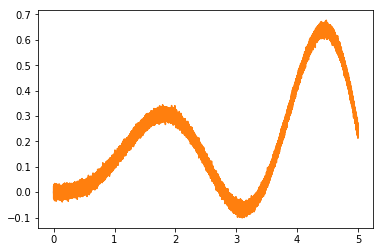

In [24]:
#Define 4th Order TRUE parameters: [a0, a1, a2, a3]
aT = np.array([1.0, 5.0, 5.0, 0.0])

#Define initial conditions
x0 = [0.0, 0.0, 0.0, 1.0]

#Set time interval [a, b] and number of points to generate linear system
a, b, points = 0, 5, 200000

#Set standard deviation for additive white gaussian noise
std = 0.01

#Generate noisy signal yM and noiseless signal yT
yM, yT,dyT, ddyT, dddyT, t = states_system(a, b, points, x0, aT, std)
#Verify noise is white
print("mean = ", np.mean(yM - yT))
print("variance = ", np.var(yM - yT))
plt.figure()
plt.plot(t,yT)
plt.plot(t,yM)
plt.show()

In [25]:
def window_adjust(t,yM, a, end):
    print("a is",a)
    dynamic_range=0
    previous_dr = dynamic_range
    increment = 0.5
    b=a
    while(b<end):     
        b=a + increment
        print("window is from", a, "to", b)
        t_window = np.where((t>=a) & (t<=b))[0]
        yM_window = np.take_along_axis(yM, t_window, 0)
        dynamic_range=np.ptp(yM_window)
        print("dynamic range is", dynamic_range)
        if(dynamic_range<previous_dr):
            print("returning at",b) 
            return b
        else:
            previous_dr = dynamic_range
            print("incrementing to", a+increment)
            a= a+ increment
            continue
    return b

In [26]:
new_b = window_adjust(t,yM, a=0, end=5)

a is 0
window is from 0 to 0.5
dynamic range is 0.09204702686871907
incrementing to 0.5
window is from 0.5 to 1.0
dynamic range is 0.16646545085091022
incrementing to 1.0
window is from 1.0 to 1.5
dynamic range is 0.20555630282097254
incrementing to 1.5
window is from 1.5 to 2.0
dynamic range is 0.1027271052290748
returning at 2.0


In [27]:
#Calculate SNR
signal_power = np.mean(np.square(yT))
noise_power = np.mean(np.square(yT - yM))
SNR = signal_power/noise_power
SNR_dB = 10*np.log10(SNR)
print(SNR_dB)

29.248195055428255


In [28]:
# n_max = 6
# knots = 1
# mode = 'mid_end_point'#"single_random"
# tol = 0.01
# a=0
# b=2
# ak_init = np.array([0.0, 0.0, 0.0, 0.0])
# ak1, aklog1 = RLS(yM, t, a, b, knots, mode, n_max, tol, ak_init)

# Moving window: 

a is 0
window is from 0 to 0.5
dynamic range is 0.09204702686871907
incrementing to 0.5
window is from 0.5 to 1.0
dynamic range is 0.16646545085091022
incrementing to 1.0
window is from 1.0 to 1.5
dynamic range is 0.20555630282097254
incrementing to 1.5
window is from 1.5 to 2.0
dynamic range is 0.1027271052290748
returning at 2.0
t_window size: 80000
YM_window size: 80000

seed=  0

 t_knots=  [1.0000125 2.       ]
0 [0. 0. 0. 1.]
2

 tk=  [1.0000125 2.       ]

 n=  2
tk is [1.0000125 2.       ]
start time  [1.0000125 2.       ]

 n=  3
tk is [1.0000125 2.       ]
start time  [1.0000125 2.       ]

 n=  4
tk is [1.0000125 2.       ]
start time  [1.0000125 2.       ]

 n=  5
tk is [1.0000125 2.       ]
start time  [1.0000125 2.       ]
eta [[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [0.00000000e+00 2.50003125e-05 5.00006250e-05 ... 1.99995000e+00
  1.99997500e+00 2.00000000e+00]
 [0.00000000e+00 6.25015625e-10 2.50006250e-09 ... 


 n=  5
tk is [3.7500125 4.5      ]
start time  [3.7500125 4.5      ]
eta [[ 3.96336719  3.96324823  3.96312925 ... -6.27351806 -6.27307769
  -6.27263728]
 [ 2.97640698  2.97667548  2.97694398 ... -9.07772786 -9.07821111
  -9.07869433]
 [-1.31813554 -1.3182008  -1.31826607 ... -6.21416747 -6.21425102
  -6.21433456]
 [ 3.15826528  3.15827606  3.15828684 ...  1.21030656  1.21021715
   1.21012774]]
u: [[ 0.54116079  0.54114455  0.5411283  ... -0.85659033 -0.8565302
  -0.85647006]
 [ 0.4038881   0.40393524  0.40398237 ... -1.36243402 -1.36252395
  -1.36261387]
 [-1.51587234 -1.51584409 -1.51581584 ... -2.04679453 -2.04700905
  -2.04722356]
 [ 2.23805693  2.23777843  2.23749994 ... -2.17987053 -2.18035484
  -2.18083919]]
ak is [ 3.35721815 -5.2446845   7.08965956 -1.88734656] in get_KDSn
ak is [ 3.35721815 -5.2446845   7.08965956 -1.88734656] in get_KDSn
ak is [ 3.35721815 -5.2446845   7.08965956 -1.88734656] in get_KDSn
ak is [ 3.35721815 -5.2446845   7.08965956 -1.88734656] in get_KDSn
ak

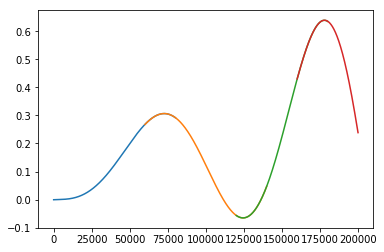

In [29]:
n_max = 6
knots = 1
mode = 'mid_end_point'#"single_random"
tol = 0.0001
window_size=1
end = 5

#for logging
ltv_a=[]
t_window_log=[]
yE_window_log=[]
yM_window_log= []
dy1_log = []
dy2_log = []
#initialize
a=0
b = a + window_size
ak1 = np.array([0.0, 0.0, 0.0, 1.0])

y_exp= np.zeros_like(yM)

while(b <= end-0.5):        
    b = window_adjust(t,yM, a, end)
    #this part is to section the signal into smaller horizons
    t_window = np.where((t>=a) & (t<=b))[0]
    print("t_window size:",t_window.size)
    t_new = np.linspace(a,b,t_window.size)
    yM_window = np.take_along_axis(yM, t_window, 0)
    print("YM_window size:",yM_window.size)
    
    #This is to use the previous estimate as an initial condition to the next one
    ak_init=ak1
    ak1, aklog1 = RLS(yM_window, t_new, a, b, knots, mode, n_max, tol, ak_init)
    print("**************Reconstructing signal **********************")
    yE_1 = get_yE(yM_window, t_new, ak1)
    
    print("YE size:",yE_1.size)
    dy1 = np.zeros(yE_1.shape,np.float)
    dy1[0:-1] = np.diff(yE_1)/np.diff(t_new)
    
    dy2 = np.zeros(dy1.shape,np.double)
    dy2[0:-1] = np.diff(dy1)/np.diff(t_new)

    
    
    #logging and plotting
    y_exp[t_window[0]:t_window[-1]+1]= yE_1
    ltv_a.append(ak1)
    yE_window_log.append(yE_1)
    t_window_log.append(t_window)
    plt.plot(t_window, yE_1)
    dy1_log.append(dy1[0:-1])
    dy2_log.append(dy2[0:-2])
    #shift the window by half
    a = b-0.5

plt.show()

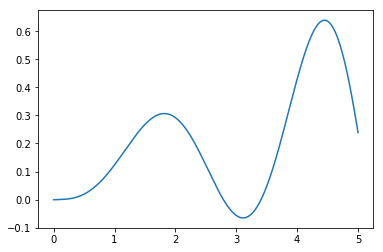

In [30]:
plt.figure()
plt.plot(t,y_exp)

dy1_exp = np.zeros(y_exp.shape,np.float)
dy1_exp[0:-1] = np.diff(y_exp)/np.diff(t)
dy2_exp = np.zeros(dy1_exp[:-1].shape,np.float)
dy2_exp[0:-2] = np.diff(dy1_exp[:-2])/np.diff(t[:-2])


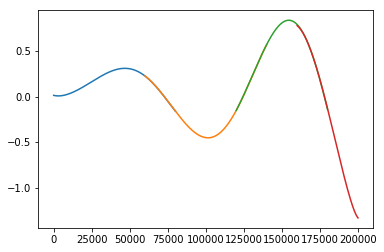

In [31]:
plt.figure()
for x, t_window in enumerate(t_window_log):
    plt.plot(t_window[0:-1], dy1_log[x])
plt.show()

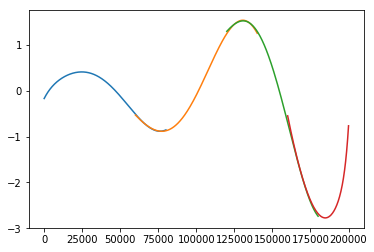

In [32]:
plt.figure()
for x, t_window in enumerate(t_window_log):
    plt.plot(t_window[0:-2], dy2_log[x])
plt.show()

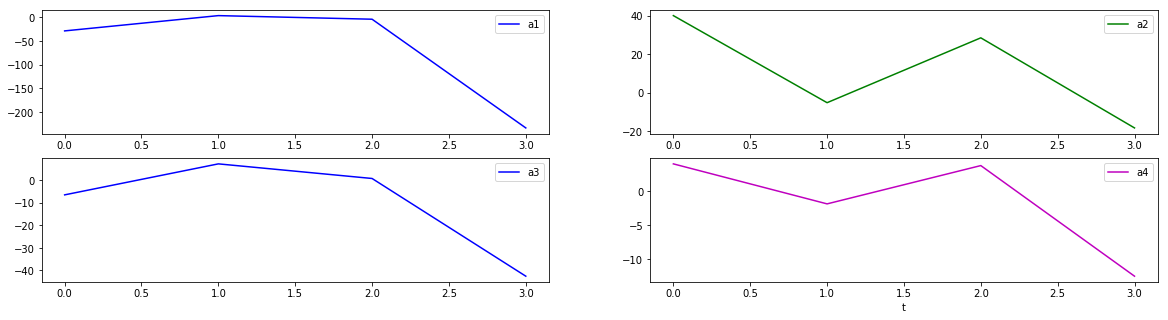

In [33]:
a1_list=[]
a2_list=[]
a3_list=[]
a4_list=[]
for i in range(0,len(ltv_a)):
    a1_list.append(ltv_a[i][0])
    a2_list.append(ltv_a[i][1])
    a3_list.append(ltv_a[i][2])
    a4_list.append(ltv_a[i][3])
t_a = np.arange(0,len(ltv_a),1)
plt.figure(figsize=(20,5))
plt.subplot(2, 2, 1)
plt.plot(t_a, a1_list, 'b', label='a1')
plt.legend(loc='best')
plt.subplot(2, 2, 2)
plt.plot(t_a, a2_list, 'g', label='a2')
plt.legend(loc='best')
plt.subplot(2, 2, 3)
plt.plot(t_a, a3_list, 'b', label='a3')
plt.legend(loc='best')
plt.subplot(2, 2, 4)
plt.plot(t_a, a4_list, 'm', label='a4')
plt.legend(loc='best')
plt.xlabel('t')
plt.show()

In [34]:
def get_KFn_1_vector(ti, tau_F, a, order, derivative):
    if tau_F.size == 1:
        tau_F = np.array([tau_F])
    N_tau = tau_F.shape[0]
    f = np.math.factorial
    gamma = np.zeros((order-1, N_tau))
    zeta = np.zeros((order+1, N_tau))
    delta = np.array(tau_F - a)
    n = order
    k = derivative
    p = n-k
    for i in range(0, order-1):
        gamma[i, :] = np.array(((ti - tau_F)**(i))/(f(i)))
        # print('gamma',gamma)
    # a=0.0
    for j in range(1, p+1):
        zeta[order, :] = zeta[order, :]+(((-1)**(j+n-p+1)) * gamma[j-1, :] * ((delta**(p-j))/f(
            p-j)) * (f(order)/(f(n-p+j)*f(order-n+p-j))) * f(order))  # *(np.ones(N_tau))) #const
    #print('outp ',zeta[order,:])
    # print('ti',ti)
    # print('tauF',tau_F)
    for i in range(0, p):
        # zeta[i,:]=np.zeros(N_tau)
        if i == 0:
            j = 0
            zeta[i, :] = zeta[i, :]+(gamma[p-i+j-1, :] * ((delta**(n-j))/f(n-j))
                                     * ((-1)**(j+1)) * (f(i)/(f(j)*f(i-j))) * f(order))
        else:
            for j in range(0, i+1):
                zeta[i, :] = zeta[i, :]+(gamma[p-i+j-1, :] * ((delta**(n-j))/f(n-j)) * (
                    (-1)**(j+1)) * (f(i)/(f(j)*f(i-j))) * f(order))

    for i in range(p, n):
        # zeta[i,:]=np.zeros(N_tau)
        if i == 0:
            j = 0
            zeta[i, :] = zeta[i, :]+(gamma[j-1, :] * ((delta**(n-j+p-i))/f(n-j+p-i)) * (
                (-1)**(j+i-p+1)) * (f(i)/(f(i-p+j)*f(p-j))) * f(order))
        else:
            for j in range(1,p+1):#(0,i+1):#(1, p+1):
                #print('i',i)
                #print('j',j)
                #print('p',p)
                #print('n',n)

                zeta[i, :] = zeta[i, :]+(gamma[j-1, :] * ((delta**(n-j+p-i))/f(n-j+p-i)) * (
                    (-1)**(j+i-p+1)) * (f(i)/(f(i-p+j)*f(p-j))) * f(order))
                #print(zeta[i,:])
    return zeta

In [35]:
def get_KBn_1_vector(ti, tau_B, b, order, derivative):
    if tau_B.size == 1:
        tau_B = np.array([tau_B])
    N_tau = tau_B.shape[0]
    f = np.math.factorial
    gamma = np.zeros((order-1, N_tau))
    zeta = np.zeros((order+1, N_tau))
    delta = np.array(b - tau_B)
    n = order
    k = derivative
    p = n-k
    for i in range(0, order-1):
        gamma[i, :] = np.array(((ti - tau_B)**(i))/(f(i)))
    # a=0.0
    for j in range(1, p+1):
        zeta[order, :] = zeta[order, :]+(gamma[j-1, :] * ((delta**(p-j))/f(p-j)) * (
            f(order)/(f(n-p+j)*f(order-n+p-j))) * f(order))  # *(np.ones(N_tau))) #const
    #print('outpB ',zeta[order,:])
    # print('ti',ti)
    # print('tauF',tau_F)
    for i in range(0, p):
        # zeta[i,:]=np.zeros(N_tau)
        if i == 0:
            j = 0
            zeta[i, :] = zeta[i, :]+(gamma[p-i+j-1, :] *
                                     ((delta**(n-j))/f(n-j)) * (f(i)/(f(j)*f(i-j))) * f(order))
        else:
            for j in range(0, i+1):
                zeta[i, :] = zeta[i, :]+(gamma[p-i+j-1, :] * (
                    (delta**(n-j))/f(n-j)) * (f(i)/(f(j)*f(i-j))) * f(order))

    for i in range(p, n):
        # zeta[i,:]=np.zeros(N_tau)
        if i == 0:
            j = 0
            zeta[i, :] = zeta[i, :]+(gamma[j-1, :] * ((delta**(n-j+p-i)) /
                                                      f(n-j+p-i)) * (f(i)/(f(i-p+j)*f(p-j))) * f(order))
        else:
            for j in range(1,p+1):#(0,i+1):#(1, p+1):
                zeta[i, :] = zeta[i, :]+(gamma[j-1, :] * (
                    (delta**(n-j+p-i))/f(n-j+p-i)) * (f(i)/(f(i-p+j)*f(p-j))) * f(order))
    return zeta

In [36]:
def get_y_derivative(y, t, a, b, ak, order, derivative):
    f = np.math.factorial
    N = t.shape[0]
    RHS_n = np.zeros((N, order+1))
    beta = np.concatenate((ak, 1), axis=None)
    beta = beta.reshape(order+1, 1)
    r = 0
    for ti in t:
        #print(ti)
        #for i in range(1,11):
        if ti==t[int(t.shape[0]*(2.5/10))]:
            print('25% done')
        elif ti==t[int(t.shape[0]*(5/10))]:
            print('50% done')
        elif ti==t[int(t.shape[0]*(7.5/10))]:
            print('75% done')
        elif ti==t[int(t.shape[0]*(9.9/10))]:
            print('99% done')
        
        tau_F, tau_B = get_tau(y, t, ti)
        # Calculate Kernel vector
        # alpha = get_alpha_tau(ti, tau_F, tau_B, a, b, n=1) #(t-a)**4+(b-t)**4
        KFn_vector = get_KFn_1_vector(ti, tau_F, a, order, derivative)
        KBn_vector = get_KBn_1_vector(ti, tau_B, b, order, derivative)
        KDSn_vector = np.concatenate((KFn_vector, KBn_vector), axis=1)
        # Calculate integrands
        integrand = np.multiply(KDSn_vector, y)
        # print(integrand)
        # print('*'*10)
        integrand = np.multiply(beta, integrand)

        # Integrate
        for k in range(0, order+1):
            RHS_n[r, k] = np.trapz(integrand[k, :], t)
        r += 1
        KDSn = np.sum(RHS_n, axis=1)
        # print('shape',RHS_n.shape)
    return KDSn  # RHS_n

In [37]:
def get_KF_vector(y_all, ti, a, ak, order, derivative):
    N_tau = ti.shape[0]
    f = np.math.factorial
    beta = np.concatenate((ak, 1), axis=None)
    beta = beta.reshape(order+1, 1)
    zeta = np.zeros((order+1, N_tau))
    delta = np.array(ti - a)
    n = order
    k = derivative
    p = n-k

    for i in range(1, k+1):
        zeta[order, :] = zeta[order, :]+(((-1)**(i+1)) * ((delta**(n-i))/f(n-i)) * (
            f(p+i-1)/(f(i)*f(p-1))) * f(n) * y_all[:, k-i])   # *(np.ones(N_tau))) #const
        '''print('y_est', y_all[:, k-i])
        print('delta power',n-i)
        print('ti-a', delta**(n-i))
        print('const', (((-1)**(i+1))/f(n-i)) * (
                    f(p+i-1)/(f(i)*f(p-1))) * f(n))
        print('outp ', zeta[order, :])
        print('i',i)
    print(order)'''

    # print('ti',ti)
    # print('tauB',tau_B)

    for i in range(p, order):
        # zeta[i,:]=np.zeros(N_tau)
        if i == 0:
            j = 0
            zeta[i, :] = zeta[i, :] + (((-1)**(j+1)) * ((delta**(n-j))/f(n-j))
                                       * (f(p+j-1)/(f(j)*f(p-1))) * f(n) * y_all[:, i-j-p])
        else:
            for j in range(0, i-p+1):
                zeta[i, :] = zeta[i, :] + (((-1)**(j+1)) * ((delta**(n-j))/f(n-j)) * (
                    f(p+j-1)/(f(j)*f(p-1))) * f(n) * y_all[:, i-j-p])  # p=3,i=3,j=0
            '''print('y_est', y_all[:, i-j-p])
            print('delta power',n-j)
            print('ti-a', delta**(n-j))
            print('const', (((-1)**(j+1))/f(n-j)) * (
                    f(p+j-1)/(f(j)*f(p-1))) * f(n))
            print('outp ', zeta[i, :])
            print('order',i)
                #print('y_est', y_all[:, i-j-p])
                #print('ti-a', delta**(n-j))
                #print('const', (((-1)**(j))/f(n-j)) * (
                 #   f(p+j-1)/(f(j)*f(p-1))) * f(n))
        print('outpu ', zeta[i, :])
        print(i)'''
    #print('beta', beta)
    ans = np.multiply(beta, zeta)
    return ans

In [38]:
def get_KB_vector(y_all, ti, b, ak, order, derivative):
    N_tau = ti.shape[0]
    f = np.math.factorial
    #gamma = np.zeros((order, N_tau))
    beta = np.concatenate((ak, 1), axis=None)
    beta = beta.reshape(order+1, 1)
    zeta = np.zeros((order+1, N_tau))
    delta = np.array(b - ti)
    n = order
    k = derivative
    p = n-k
    # for i in range(0, order):
    #    gamma[i, :] = np.array(((ti - tau_B)**(n+i))/(f(n+i)))

    for i in range(1, k+1):
        zeta[order, :] = zeta[order, :]+(((delta**(n-i))/f(n-i)) * (
            f(p+i-1)/(f(i)*f(p-1))) * f(n) * y_all[:, k-i])   # *(np.ones(N_tau))) #const
        '''print('y_est', y_all[:, k-i])
        print('delta power',n-i)
        print('ti-a', delta**(n-i))
        print('const', (1/f(n-i)) * (
                    f(p+i-1)/(f(i)*f(p-1))) * f(n))
        print('outp ', zeta[order, :])
        print('i',i)
    #print('outpB ', zeta[order, :])
    print(order)'''

    # print('ti',ti)
    # print('tauB',tau_B)

    for i in range(p, order):
        # zeta[i,:]=np.zeros(N_tau)
        if i == 0:
            j = 0
            zeta[i, :] = zeta[i, :] + (((delta**(n-j))/f(n-j))
                                       * (f(p+j-1)/(f(j)*f(p-1))) * f(n) * y_all[:, i-j-p])
        else:
            for j in range(0, i-p+1):
                zeta[i, :] = zeta[i, :] + (((delta**(n-j))/f(n-j))
                                           * (f(p+j-1)/(f(j)*f(p-1))) * f(n) * y_all[:, i-j-p])
            '''print('y_est', y_all[:, i-j-p])
            print('delta power',n-j)
            print('ti-a', delta**(n-j))
            print('const', (1/f(n-j)) * (
                    f(p+j-1)/(f(j)*f(p-1))) * f(n))
            print('outp ', zeta[i, :])
            print('order',i)
        #print('outpuB ', zeta[i, :])
        print(i)'''
    ans = -np.multiply(beta, zeta)
    return ans

In [39]:

order = 4
order_max = 6
order_min = 2
yE=np.zeros((t.shape[0],order_max-order_min))

yE[:,order-order_min]=y_exp
#a__est[:order,order-order_min]=a_est

derivative = 1
ak1= a__est[:order,order-order_min]
y_all = np.zeros((y.shape[0], order))
y_all[:, 0] =  yE[:,order-order_min]
y_n = yE[:,order-order_min]
y_dot_est_F_int = np.zeros_like(y_n)
y_dot_est_F = np.zeros_like(y_dot_est_F_int)
y_dot_est_B_int = np.zeros_like(y_n)
y_dot_est_B = np.zeros_like(y_dot_est_B_int)
y_dot_est = np.zeros_like(y_n)
out = get_y_derivative(y, t, a, b, ak1, order, derivative)
y_dot_est_F_int = get_KF_vector(y_all, t, a, ak1, order, derivative)
y_dot_est_B_int = get_KB_vector(y_all, t, b, ak1, order, derivative)
y_dot_est_KD = np.sum(y_dot_est_F_int+y_dot_est_B_int, axis=0)
y_dot_est = (y_dot_est_KD + out) / \
    (((t-a)**order)+((b-t)**order))

MAD1 = 0.0
j=0
for i in range(t.shape[0]):
    if ydot[i]-y_dot_est[i] > MAD1:
        MAD1 = ydot[i]-y_dot_est[i]
        j=i
print('MAD 1=', MAD1)
print('max pt',j)


#plt.figure(figsize=(15, 8))
plt.figure(dpi=175)
lab_t='True y^'+str(derivative)+'(order '+str(order)+')'
lab_e='Estimated y^'+str(derivative) +'(order '+str(order)+')'
plt.plot(t, ydot, label=lab_t)
plt.plot(t, y_dot_est, label=lab_e)
plt.xlabel('time (sec)')
plt.legend()
#plt.savefig('C:/Users/admin/Desktop/Estimation of y_dot (sd=2 60k).pdf')
plt.show()
'''

derivative1=2
y_all[:,1] = y_dot_est
y_ddot_est_F_int = np.zeros_like(y_n)
y_ddot_est_F = np.zeros_like(y_ddot_est_F_int)
y_ddot_est_B_int = np.zeros_like(y_n)
y_ddot_est_B = np.zeros_like(y_ddot_est_B_int)
y_ddot_est = np.zeros_like(y_n)
out_d = get_y_derivative(y, t, a, b, ak1, order, derivative1)
y_ddot_est_F_int = get_KF_vector(y_all, t, a, ak1, order, derivative1)
y_ddot_est_B_int = get_KB_vector(y_all, t, b, ak1, order, derivative1)
y_ddot_est_KD = np.sum(y_ddot_est_F_int+y_ddot_est_B_int, axis=0)
y_ddot_est = (y_ddot_est_KD + out_d) / \
    (((t-a)**order)+((b-t)**order))

MAD2 = 0.0
j=0
for i in range(t.shape[0]):
    if ydotdot[i]-y_ddot_est[i] > MAD2:
        MAD2 = ydotdot[i]-y_ddot_est[i]
        j=i
print('MAD 2=', MAD2)
print('max pt',j)

#plt.figure(figsize=(15, 8))
plt.figure(dpi=175)
lab_t='True y^'+str(derivative1)+'(order '+str(order)+')'
lab_e='Estimated y^'+str(derivative1) +'(order '+str(order)+')'
plt.plot(t, ydotdot, label=lab_t)
plt.plot(t, y_ddot_est, label=lab_e)
plt.xlabel('time (sec)')
plt.legend()
#plt.savefig('C:/Users/admin/Desktop/Estimation of y_dot (sd=2 60k).pdf')
plt.show()'''

NameError: name 'a__est' is not defined